loading data from /Users/tempflip/Desktop/rec2/
(24314, 7)
(3045, 7)


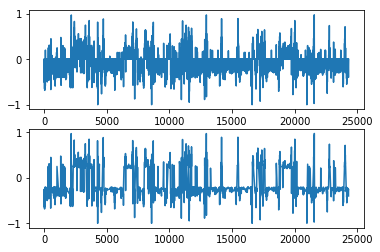

In [1]:
onServer = False

MIN_STEERING = 0.20
L_R_STEERING_ADJUST = 0.2

import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

HOME_ROOT = '/Users/tempflip/Desktop/'
SERVER_ROOT = '/home/carnd/'


#SERVER_LOG_DIR = '/home/carnd/track2/'
#SERVER_LOG_DIR2 = '/home/carnd/rec2/'

SERVER_LOG_DIR = '/Users/tempflip/Desktop/track2/'
SERVER_LOG_DIR2 = '/Users/tempflip/Desktop/rec2/'


LOG_FILE  = 'driving_log.csv'

#if onServer : dr = SERVER_LOG_DIR
#else : dr = LOG_DIR

row_list = []
def add_rows_to_rowlist(row_list, log_dir):
    print ('loading data from', log_dir)
    with open(log_dir + '/' + LOG_FILE, 'r') as f:
        reader = csv.reader(f)
        for row in reader:
            if(onServer == True):
                row[0] = row[0].replace(HOME_ROOT, SERVER_ROOT)
                row[1] = row[1].replace(HOME_ROOT, SERVER_ROOT)
                row[2] = row[2].replace(HOME_ROOT, SERVER_ROOT)
            row_list.append(row)
    return row_list

#row_list = add_rows_to_rowlist(row_list, SERVER_LOG_DIR)
row_list = add_rows_to_rowlist(row_list, SERVER_LOG_DIR2)

log = []    
log = pd.DataFrame([row for row in row_list], columns=['CENTER', 
                                                         'LEFT',
                                                         'RIGHT',
                                                         'STEERING',
                                                         'THROTTLE',
                                                         'BRAKE',
                                                         'SPEED'
                                                        ])

log['STEERING'] = pd.to_numeric(log['STEERING'])

plt.subplot(2,1,1)
plt.plot(log['STEERING'])

print (log.values.shape)

clean_log = log[log['STEERING'].abs() > MIN_STEERING]


plt.subplot(2,1,2)
plt.plot(clean_log['STEERING'])


log = clean_log
print (log.values.shape)

#log['STEERING'] *= STEERING_ADJUST


In [4]:
print(log.iloc[3000])


CENTER      /Users/tempflip/Desktop/rec2/IMG/center_2017_0...
LEFT        /Users/tempflip/Desktop/rec2/IMG/left_2017_03_...
RIGHT       /Users/tempflip/Desktop/rec2/IMG/right_2017_03...
STEERING                                              0.29421
THROTTLE                                            0.2048489
BRAKE                                                       0
SPEED                                                22.33322
Name: 24039, dtype: object


In [5]:
from scipy import misc
im_list = []
steering_targets = []

data_list = []

item_num = len(log['CENTER'].values)
#item_num = 2000

for i in range(item_num):
    c, l, r = log[['CENTER', 'LEFT', 'RIGHT']].values[i]  
    data_list.append((c, log['STEERING'].values[i]))

print (len(data_list), 'points')



3045 points


In [6]:
from sklearn.utils import shuffle
# the generator
def generator(point_list, batch_size=100):  
    batch_size = int(batch_size / 2) # we are returning 2 images for one (flipped)
    while 1:
        point_list = shuffle(point_list)
        X, Y = [], []
        
        for i in range(batch_size):
            path, angle = point_list[i]
            angle = float(angle)
            im = misc.imread(path)
                        
            X.append(im)
            Y.append(angle)
            
            # the flipped image
            X.append(np.fliplr(im))
            Y.append(angle * -1)
            
        yield np.array(X, dtype=np.float32), np.array(Y)



In [21]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Dropout, Lambda
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras import backend as K

def crop(d):
    return d[:,80:120,:,:]
    #return d[:,60:120,:,:]

def normalize(d):
    return d / 255 - 0.5

def reduce_palette(d):
    import tensorflow as tf 
    n = 40
    #n = 2
    return tf.ceil((d/n)*n)

def greyscale(d):
    import tensorflow as tf 
    r, g, b = tf.split(d, num_or_size_splits=3, axis=3)
    return (r + g + b) / 3

model = Sequential()

model.add(Lambda(reduce_palette, input_shape=(160, 320, 3)))
#model.add(Lambda(greyscale))
model.add(Lambda(normalize))
model.add(Lambda(crop))


model.add(Convolution2D(9,3,3, border_mode="same", name="conv1"))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.1)) #!!!!!!!!!
model.add(Activation('relu', name="relu1"))

model.add(Convolution2D(18,3,3, border_mode="same", name="conv2"))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.1)) #!!!!!!!!!!
model.add(Activation('relu', name="relu2"))


model.add(Flatten())

model.add(Dense(10))
model.add(Dense(1))

#print(model.inputs)
print(model.outputs)




[<tf.Tensor 'add_40:0' shape=(?, 1) dtype=float32>]


0.3204308


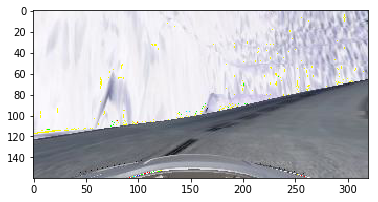

In [162]:
# some filter tests
g = generator(data_list, batch_size=20)
img, angle = next(g)
print (angle[0])

plt.imshow(img[0])

In [163]:
gen = generator(data_list, batch_size=500)
val_gen = generator(data_list, batch_size=100)

model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
history = model.fit_generator(gen, samples_per_epoch = 10000, nb_epoch=10, validation_data=val_gen, nb_val_samples=100)


Epoch 1/10
10000/10000 [==============================] - 12s - loss: 0.3980 - acc: 0.0203 - val_loss: 0.2170 - val_acc: 0.0000e+00

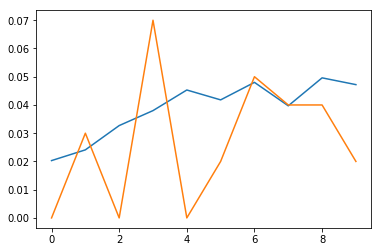

In [164]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

In [165]:
model.save('/home/carnd/mod.h5')
#model.save('./my_model.h5')
print("Saved.")

Saved.


In [7]:
######################################################
######################################################
######################################################
######################################################
######################################################
######################################################
######################################################
#
# This is the end of the project.
# From this point on i'm making some model visualizations
# This code might be broken
#
######################################################
######################################################
######################################################
######################################################

In [8]:
from keras.models import load_model
from keras import backend as K
#from keras.utils.visualize_util import plot

m = load_model('./mod.h5')
m.load_weights('./mod.h5')


Using TensorFlow backend.


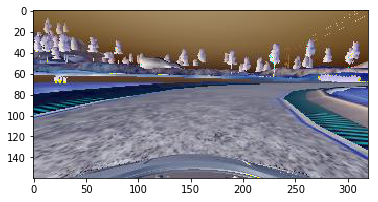

In [9]:
g = generator(data_list, batch_size=10)
_img, angle = next(g)
img = _img[0]
plt.imshow(img)

In [10]:
layer_dict = dict([(l.name, l) for l in m.layers] )
#m.summary()


In [25]:
#building an another model for visualizing
#######
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Dropout, Lambda
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D

vis_model = Sequential()
vis_model.add(Lambda(reduce_palette, input_shape=(160, 320, 3), name="start"))
vis_model.add(Lambda(normalize))
vis_model.add(Lambda(crop))
vis_model.add(Convolution2D(9,3,3, border_mode="same", 
                            name="conv1", 
                            #input_shape=(40, 320, 3)
                           ))
vis_model.add(MaxPooling2D((2,2)))
vis_model.add(Activation('relu', name="relu1"))

vis_model.add(Convolution2D(18,3,3, border_mode="same", name="conv2"))
vis_model.add(MaxPooling2D((2,2)))
vis_model.add(Activation('relu', name="relu2"))
vis_model.add(Flatten())
vis_model.add(Dense(10))
vis_model.add(Dense(1, name="dense_out"))


vis_model.layers[3].set_weights(layer_dict['conv1'].get_weights())
vis_model.layers[4].set_weights(layer_dict['maxpooling2d_29'].get_weights())
vis_model.layers[5].set_weights(layer_dict['relu1'].get_weights())
vis_model.layers[6].set_weights(layer_dict['conv2'].get_weights())
vis_model.layers[7].set_weights(layer_dict['maxpooling2d_30'].get_weights())
vis_model.layers[8].set_weights(layer_dict['relu2'].get_weights())
vis_model.layers[9].set_weights(layer_dict['flatten_15'].get_weights())
vis_model.layers[10].set_weights(layer_dict['dense_29'].get_weights())
vis_model.layers[11].set_weights(layer_dict['dense_30'].get_weights())

vis_layer_dict = dict([(l.name, l) for l in vis_model.layers] )
vis_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
start (Lambda)                   (None, 160, 320, 3)   0           lambda_input_14[0][0]            
____________________________________________________________________________________________________
lambda_25 (Lambda)               (None, 160, 320, 3)   0           start[0][0]                      
____________________________________________________________________________________________________
lambda_26 (Lambda)               (None, 40, 320, 3)    0           lambda_25[0][0]                  
____________________________________________________________________________________________________
conv1 (Convolution2D)            (None, 40, 320, 9)    252         lambda_26[0][0]                  
___________________________________________________________________________________________

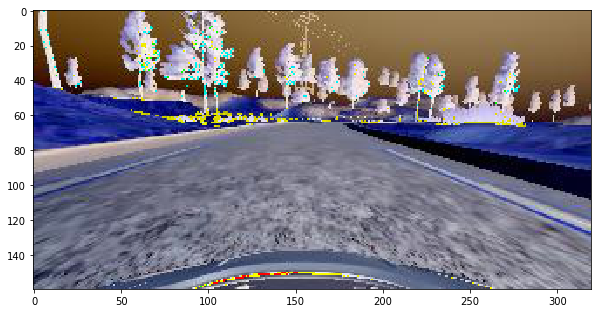

In [82]:
n = 2
plt.imshow(_img[n])

(10, 20, 160, 9)


IndexError: index 9 is out of bounds for axis 3 with size 9

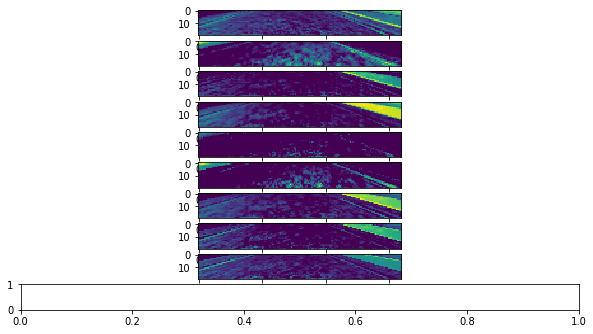

In [85]:
from keras.models import Model
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10, 10)

int_model = Model(input = vis_model.input, output = vis_layer_dict['relu1'].output)
_pr = int_model.predict(_img)

print (_pr.shape)

for i in range(18):
    plt.subplot(18,1,i+1)
    plt.imshow(_pr[n,:,:,i])


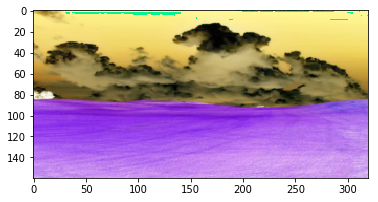

In [37]:
#chessboard = misc.imresize(misc.imread('./tablecolor.jpg'), (40,320))
chessboard = np.array(misc.imresize(misc.imread('./field.jpg'), (160,320)),dtype=np.float32)
plt.imshow(chessboard)

0.0400852
0.0401248
0.0401643
0.0402038
0.0402432
0.0402826
0.0403219
0.0403612
0.0404004
0.0404395


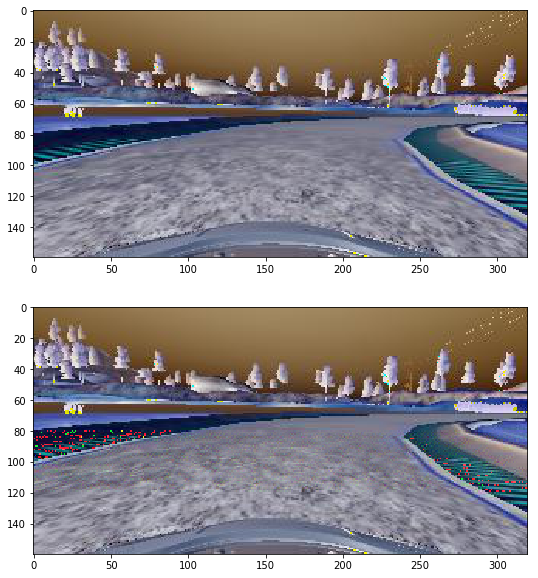

In [143]:
layer_input = vis_layer_dict['lambda_25'].input
layer_output = vis_layer_dict['relu2'].output

e = 10
step = 1
filter_index = 1
input_img = np.array(_img)

plt.subplot(2,1,1)
plt.imshow(input_img[0])

loss = K.mean(layer_output[:, :, :, filter_index])
grads = K.gradients(loss, [layer_input])[0]
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

fn = K.function([layer_input], [loss,grads]) #function to call the gradient

for i in range(e):
    l, g = fn([input_img])
    input_img += g * step
    #plt.subplot(e + 1, 1, i+1)
    #plt.imshow(input_img[0])    
    #print('min, max', np.min(input_img), np.max(input_img))
    print(l)


plt.subplot(2,1,2)
plt.imshow(input_img[0])


In [51]:

matplotlib.rcParams['figure.figsize'] = (10.0, 20.0)

#input_img = np.floor(input_img * np.max(input_img))
print(np.min(input_img), np.max(input_img))
print(np.min(g), np.max(g))

plt.subplot(input_img.shape[3] +2, 1, 1)
plt.imshow(input_img[0])

for i in range(0,input_img.shape[3]):
    plt.subplot(input_img.shape[3] +2, 1, i+2)
    plt.imshow(input_img[0,:,:,i])

NameError: name 'matplotlib' is not defined